In [1]:
import datetime as dt
import logging
import re

import click
import matplotlib as mpl
import matplotlib.cm  # noqa
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from cycler import cycler

import numpy as np
import patsy
import yaml

import yatsm
from yatsm.cli import options, console
from yatsm.algorithms import postprocess
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.regression.transforms import harm  # noqa


In [2]:
# set style preferences
plt.style.use('dark_background') 
#plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams['grid.color'] = '0.5'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = '1'
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 12

In [3]:
SEASONS = {
    'winter': ((11, 12, 1, 2, 3), 'b', 0.5),
    'spring': ((4, 5), 'c', 0.5),
    'summer': ((6, 7, 8), 'g', 1.,),
    'fall': ((9, 10), 'y', 0.5)
}

In [4]:
_DEFAULT_PLOT_CMAP = 'viridis'
PLOT_CMAP = _DEFAULT_PLOT_CMAP
if PLOT_CMAP not in mpl.cm.cmap_d:
    PLOT_CMAP = 'cubehelix'

In [5]:
WRS = 'p012r031'
px = 2786 #col
#px = 1864 #col
py = 2477 #row
#py = 3644 #row
band = 8
plot = 'TS'
ylim = (0, 0.4500)
style = 'ggplot'
cmap = PLOT_CMAP
embed = False
seed = 0
algo_kw = []
result_prefix = 'ols_'
seasons = True

In [8]:
def plot_TS(dates, y, seasons):
    """ Create a standard timeseries plot

    Args:
        dates (iterable): sequence of datetime
        y (np.ndarray): variable to plot
        seasons (bool): Plot seasonal symbology
    """
    
    #xmin = dt.datetime.strptime('2005 1', '%Y %j')
    xmin = dt.datetime.strptime('2003 1', '%Y %j')
    xmax = dt.datetime.strptime('2017 365', '%Y %j')

    # Plot data
    if seasons:
        months = np.array([d.month for d in dates])
        for season_months, color, alpha in SEASONS.values():
            season_idx = np.in1d(months, season_months)
            plt.plot(dates[season_idx], y[season_idx], marker='o',
                     mec=color, mfc=color, alpha=alpha, ls='')
    else:
         plt.scatter(dates, y, c='w', marker='o', edgecolors='none', s=35)
    plt.xlabel('Date')
    plt.xlim(xmin, xmax)

In [9]:
def plot_results_fit(band, cfg_fit, model, design_info,
                 result_prefix, plot_type):
    """ Plot model results

    Args:
        band (int): plot results for this band
        cfg (dict): YATSM configuration dictionary
        model (YATSM model): fitted YATSM timeseries model
        design_info (patsy.DesignInfo): patsy design information
        result_prefix (str): Prefix to 'coef' and 'rmse'
        plot_type (str): type of plot to add results to (TS, DOY, or VAL)
    """
    # Results prefix
    result_k = model.record.dtype.names
    coef_k = result_prefix + 'coef'
    rmse_k = result_prefix + 'rmse'
    if coef_k not in result_k or rmse_k not in result_k:
        raise KeyError('Cannot find result prefix "{}" in results'
                       .format(result_prefix))
    if result_prefix:
        click.echo('Using "{}" re-fitted results'.format(result_prefix))

    # Handle reverse
    step = -1 if cfg['YATSM']['reverse'] else 1

    # Remove categorical info from predictions
    design = re.sub(r'[\+\-][\ ]+C\(.*\)', '',
                    cfg['YATSM']['design_matrix'])

    i_coef = []
    for k, v in design_info.column_name_indexes.iteritems():
        if not re.match('C\(.*\)', k):
            i_coef.append(v)
    i_coef = np.sort(np.asarray(i_coef))

    _prefix = result_prefix or cfg['YATSM']['prediction']
    print(_prefix)

    for i, r in enumerate(model.record):
        label = 'Model {i} ({prefix})'.format(i=i, prefix=_prefix)
        print(plot_type)
        plot_type == 'TS'
        # Prediction
        print(r['ols_rmse'])
        #mx = np.arange(r['start'], 738000, step)
        mx = np.arange(r['start'], r['end'], step)
        mX = patsy.dmatrix(design, {'x': mx}).T

        my = np.dot(r[coef_k][i_coef, band], mX)
        my = my.astype(float)/10000
        
        mx_date = np.array([dt.datetime.fromordinal(int(_x)) for _x in mx])
        # Break
        #if r['break']:
        #    bx = dt.datetime.fromordinal(r['break'])
        #    plt.axvline(bx, c='red', lw=2)

        #elif plot_type in ('DOY', 'VAL'):
        #    yr_end = dt.datetime.fromordinal(r['end']).year
        #    yr_start = dt.datetime.fromordinal(r['start']).year
        #    yr_mid = int(yr_end - (yr_end - yr_start) / 2)#

        #    mx = np.arange(dt.date(yr_mid, 1, 1).toordinal(),
        #                   dt.date(yr_mid + 1, 1, 1).toordinal(), 1)
        #    mX = patsy.dmatrix(design, {'x': mx}).T

        #    my = np.dot(r[coef_k][i_coef, band], mX)
        #    mx_date = np.array([dt.datetime.fromordinal(d).timetuple().tm_yday
        #                        for d in mx])
#
        #    label = 'Model {i} - {yr} ({prefix})'.format(i=i, yr=yr_mid,
        #                                                 prefix=_prefix)

    plt.plot(mx_date, my, lw=2, label=label, color='r')

In [10]:
def plot_results_predict(band, cfg_predict, model, design_info,
                 result_prefix, plot_type):
    """ Plot model results

    Args:
        band (int): plot results for this band
        cfg (dict): YATSM configuration dictionary
        model (YATSM model): fitted YATSM timeseries model
        design_info (patsy.DesignInfo): patsy design information
        result_prefix (str): Prefix to 'coef' and 'rmse'
        plot_type (str): type of plot to add results to (TS, DOY, or VAL)
    """
    # Results prefix
    result_k = model.record.dtype.names
    coef_k = result_prefix + 'coef'
    rmse_k = result_prefix + 'rmse'
    if coef_k not in result_k or rmse_k not in result_k:
        raise KeyError('Cannot find result prefix "{}" in results'
                       .format(result_prefix))
    if result_prefix:
        click.echo('Using "{}" re-fitted results'.format(result_prefix))

    # Handle reverse
    step = -1 if cfg['YATSM']['reverse'] else 1

    # Remove categorical info from predictions
    design = re.sub(r'[\+\-][\ ]+C\(.*\)', '',
                    cfg['YATSM']['design_matrix'])

    i_coef = []
    for k, v in design_info.column_name_indexes.iteritems():
        if not re.match('C\(.*\)', k):
            i_coef.append(v)
    i_coef = np.sort(np.asarray(i_coef))

    _prefix = result_prefix or cfg['YATSM']['prediction']
    print(_prefix)

    for i, r in enumerate(model.record):
        label = 'Model {i} ({prefix})'.format(i=i, prefix=_prefix)
        print(plot_type)
        plot_type == 'TS'
        # Prediction
        print(r['ols_rmse'])
        mx = np.arange(r['start'], 738000, step)
        #mx = np.arange(r['start'], r['end'], step)
        mX = patsy.dmatrix(design, {'x': mx}).T

        my = np.dot(r[coef_k][i_coef, band], mX)
        my = my.astype(float)/10000
        
        mx_date = np.array([dt.datetime.fromordinal(int(_x)) for _x in mx])
        # Break
        #if r['break']:
            #bx = dt.datetime.fromordinal(r['break'])
            #plt.axvline(bx, c='red', lw=2)

        #elif plot_type in ('DOY', 'VAL'):
        #    yr_end = dt.datetime.fromordinal(r['end']).year
        #    yr_start = dt.datetime.fromordinal(r['start']).year
        #    yr_mid = int(yr_end - (yr_end - yr_start) / 2)#

        #    mx = np.arange(dt.date(yr_mid, 1, 1).toordinal(),
        #                   dt.date(yr_mid + 1, 1, 1).toordinal(), 1)
        #    mX = patsy.dmatrix(design, {'x': mx}).T

        #    my = np.dot(r[coef_k][i_coef, band], mX)
        #    mx_date = np.array([dt.datetime.fromordinal(d).timetuple().tm_yday
        #                        for d in mx])
#
        #    label = 'Model {i} - {yr} ({prefix})'.format(i=i, yr=yr_mid,
        #                                                 prefix=_prefix)

    plt.plot(mx_date, my, lw=2, label=label, color='r', ls='--')

ols_


/projectnb/landsat/users/valpasq/conda/envs/moths/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


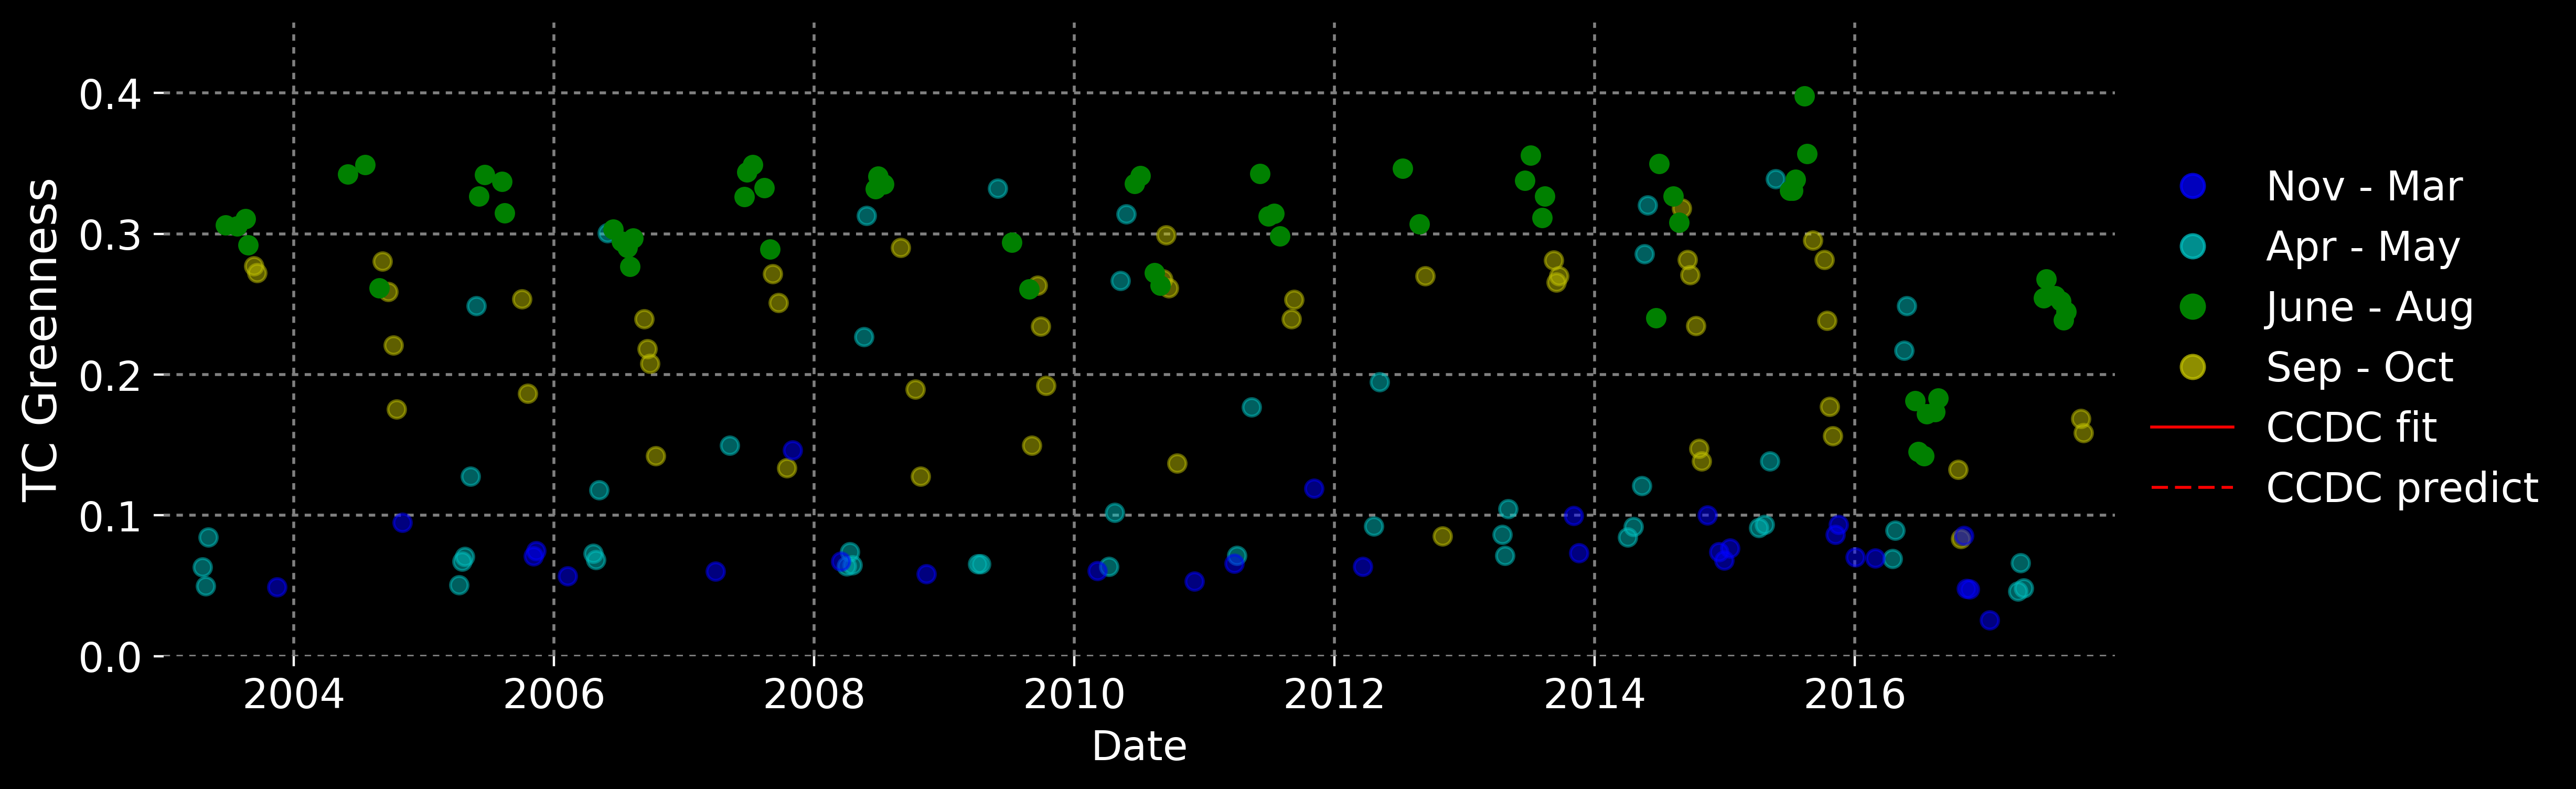

In [11]:
#def pixel(ctx, config, px, py, band, plot, ylim, style, cmap,
#          embed, seed, algo_kw, result_prefix, seasons):
    # Set seed
config_fit = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_moths_paper.yaml'
config_predict = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

start = dt.datetime.strptime('2005 01', '%Y %j')
end = dt.datetime.strptime('2016 365', '%Y %j')
    
np.random.seed(seed)

# Format result prefix
print(result_prefix)
#if result_prefix:
#    result_prefix = set((_pref if _pref[-1] == '_' else _pref + '_')
#                     for _pref in result_prefix)
#    result_prefix.add('')  # add in no prefix to show original fit
#else:
#    result_prefix = ('', )
#print(result_prefix)

# Get colormap
if cmap not in mpl.cm.cmap_d:
    raise click.ClickException('Cannot find specified colormap ({}) in '
                               'matplotlib'.format(cmap))

######################################    
# Parse config for fitting
cfg = parse_config_file(config_fit)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df = csvfile_to_dataframe(cfg['dataset']['input_file'],
                          date_format=cfg['dataset']['date_format'])
df['image_ID'] = get_image_IDs(df['filename'])
df['x'] = df['date']
dates = df['date'].values

# Initialize timeseries model
model = cfg['YATSM']['algorithm_object']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'],
              **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X = yatsm.setup(df, **cfg)
design_info = getattr(X, 'design_info', None)

# Read pixel data
Y = read_pixel_timeseries(df['filename'], px, py)
if Y.shape[0] != cfg['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df['filename'][0],
            nf=Y.shape[0],
            nc=cfg['dataset']['n_bands']))

# Preprocess pixel data
X, Y, dates = yatsm.preprocess(X, Y, dates, **cfg['dataset'])
#Y = Y.astype(float)/10000

# Convert ordinal to datetime
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

######################################    
# Parse config for predicting
cfg_pred = parse_config_file(config_predict)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df_pred = csvfile_to_dataframe(cfg_pred['dataset']['input_file'],
                          date_format=cfg_pred['dataset']['date_format'])
df_pred['image_ID'] = get_image_IDs(df_pred['filename'])
df_pred['x'] = df_pred['date']
dates_pred = df_pred['date'].values

# Initialize timeseries model
#model = ['YATSM']['algorithm_object']
algo_cfg_pred = cfg_pred[cfg_pred['YATSM']['algorithm']]
yatsm_pred = model(estimator=cfg_pred['YATSM']['estimator'],
              **algo_cfg_pred.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X_pred= yatsm.setup(df_pred, **cfg_pred)
design_info = getattr(X_pred, 'design_info', None)

# Read pixel data
Y_pred = read_pixel_timeseries(df_pred['filename'], px, py)
if Y_pred.shape[0] != cfg_pred['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df_pred['filename'][0],
            nf=Y_pred.shape[0],
            nc=cfg_pred['dataset']['n_bands']))

# Preprocess pixel data
X_pred, Y_pred, dates_pred = yatsm.preprocess(X_pred, Y_pred, dates_pred, **cfg_pred['dataset'])
Y_pred = Y_pred.astype(float)/10000

# Convert ordinal to datetime
dt_dates_pred = np.array([dt.datetime.fromordinal(d) for d in dates_pred])

# Fit model
yatsm.fit(X, Y, dates, **algo_cfg.get('fit', {}))
for prefix, estimator, stay_reg, fitopt in zip(
        cfg['YATSM']['refit']['prefix'],
        cfg['YATSM']['refit']['prediction_object'],
        cfg['YATSM']['refit']['stay_regularized'],
        cfg['YATSM']['refit']['fit']):
    yatsm.record = postprocess.refit_record(
        yatsm, prefix, estimator,
        fitopt=fitopt, keep_regularized=stay_reg)

# Plot after predictions
#plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(12,4), dpi=400)
ax1 = plt.axes(frameon=False)

#ax.plot(range(20))
#ax.axvspan(start, end, alpha=0.1, color='w')
                
with plt.xkcd() if style == 'xkcd' else mpl.style.context(style):
        #for _plot in plot:
        _plot = 'TS'   
        if _plot == 'TS':
            plot_TS(dt_dates_pred, Y_pred[band, :], seasons)
        elif _plot == 'DOY':
            plot_DOY(dt_dates, Y[band, :], cmap)
        elif _plot == 'VAL':
            plot_VAL(dt_dates, Y[band, :], cmap)

        if ylim:
            plt.ylim(ylim)
        #plt.title('Timeseries: px={px} py={py}'.format(px=px, py=py), loc='left')
        #plt.title('Example: Stable Pine Plantation')
        #plt.ylabel('Band {b}'.format(b=band + 1))

        if band == 6:
            plt.ylabel('Brightness Temp (K)', fontsize=16)
        elif band == 7:
            plt.ylabel('TC Brightness', fontsize=16)
        elif band == 8:
            plt.ylabel('TC Greenness', fontsize=16, color='w')
        elif band == 9:
            plt.ylabel('TC Wetness', fontsize=16)
        else: 
            plt.ylabel('Band {b}'.format(b=band + 1))

        #for _prefix in set(result_prefix):
        #_prefix='ols_'; # visualize only final ols results

plt.yticks(fontsize=14, color='w')
plt.xticks(fontsize=14, rotation=0, color='w')
#plt.xlabel('Date', fontsize=0, color='w')

#plt.axvline(dt.datetime.strptime('2013 1', '%Y %j'), lw=1, color='w', ls='--')
#plt.axvline(dt.datetime.strptime('2016 350', '%Y %j'), lw=1, color='w', ls='--')

winter_mk = mlines.Line2D([], [], color='b', marker='o',
                          markersize=8, label='Nov - Mar', alpha=0.75, lw=0)
summer_mk = mlines.Line2D([], [], color='g', marker='o',
                          markersize=8, label='June - Aug', alpha=1, lw=0)
spring_mk = mlines.Line2D([], [], color='c', marker='o',
                          markersize=8, label='Apr - May', alpha=0.75, lw=0)
fall_mk = mlines.Line2D([], [], color='y', marker='o',
                          markersize=8, label='Sep - Oct', alpha=0.75, lw=0)
fit_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC fit', lw=1)
predict_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC predict', lw=1, ls='--')
leg = plt.legend(handles=[winter_mk, spring_mk, summer_mk, fall_mk, fit_mk, predict_mk],
           numpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, fancybox=True)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0)

plt.grid(True)

#plt.tight_layout()
plt.show()
#ax.set_rasterized(True)
fig.savefig('{WRS}_{px}-{py}_2005-2015_TCG_justobs.png'.format(WRS=WRS, px=px, py=py), 
            bbox_extra_artists=(leg,), bbox_inches='tight', dpi=400)

In [12]:
#def pixel(ctx, config, px, py, band, plot, ylim, style, cmap,
#          embed, seed, algo_kw, result_prefix, seasons):
    # Set seed
config_fit = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_moths_paper.yaml'
config_predict = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

start = dt.datetime.strptime('2005 01', '%Y %j')
end = dt.datetime.strptime('2016 365', '%Y %j')
    
np.random.seed(seed)

# Format result prefix
print(result_prefix)
#if result_prefix:
#    result_prefix = set((_pref if _pref[-1] == '_' else _pref + '_')
#                     for _pref in result_prefix)
#    result_prefix.add('')  # add in no prefix to show original fit
#else:
#    result_prefix = ('', )
#print(result_prefix)

# Get colormap
if cmap not in mpl.cm.cmap_d:
    raise click.ClickException('Cannot find specified colormap ({}) in '
                               'matplotlib'.format(cmap))

######################################    
# Parse config for fitting
cfg = parse_config_file(config_fit)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df = csvfile_to_dataframe(cfg['dataset']['input_file'],
                          date_format=cfg['dataset']['date_format'])
df['image_ID'] = get_image_IDs(df['filename'])
df['x'] = df['date']
dates = df['date'].values

# Initialize timeseries model
model = cfg['YATSM']['algorithm_object']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'],
              **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X = yatsm.setup(df, **cfg)
design_info = getattr(X, 'design_info', None)

# Read pixel data
Y = read_pixel_timeseries(df['filename'], px, py)
if Y.shape[0] != cfg['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df['filename'][0],
            nf=Y.shape[0],
            nc=cfg['dataset']['n_bands']))

# Preprocess pixel data
X, Y, dates = yatsm.preprocess(X, Y, dates, **cfg['dataset'])
#Y = Y.astype(float)/10000

# Convert ordinal to datetime
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

######################################    
# Parse config for predicting
cfg_pred = parse_config_file(config_predict)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df_pred = csvfile_to_dataframe(cfg_pred['dataset']['input_file'],
                          date_format=cfg_pred['dataset']['date_format'])
df_pred['image_ID'] = get_image_IDs(df_pred['filename'])
df_pred['x'] = df_pred['date']
dates_pred = df_pred['date'].values

# Initialize timeseries model
#model = ['YATSM']['algorithm_object']
algo_cfg_pred = cfg_pred[cfg_pred['YATSM']['algorithm']]
yatsm_pred = model(estimator=cfg_pred['YATSM']['estimator'],
              **algo_cfg_pred.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X_pred= yatsm.setup(df_pred, **cfg_pred)
design_info = getattr(X_pred, 'design_info', None)

# Read pixel data
Y_pred = read_pixel_timeseries(df_pred['filename'], px, py)
if Y_pred.shape[0] != cfg_pred['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df_pred['filename'][0],
            nf=Y_pred.shape[0],
            nc=cfg_pred['dataset']['n_bands']))

# Preprocess pixel data
X_pred, Y_pred, dates_pred = yatsm.preprocess(X_pred, Y_pred, dates_pred, **cfg_pred['dataset'])
Y_pred = Y_pred.astype(float)/10000

# Convert ordinal to datetime
dt_dates_pred = np.array([dt.datetime.fromordinal(d) for d in dates_pred])

# Fit model
yatsm.fit(X, Y, dates, **algo_cfg.get('fit', {}))
for prefix, estimator, stay_reg, fitopt in zip(
        cfg['YATSM']['refit']['prefix'],
        cfg['YATSM']['refit']['prediction_object'],
        cfg['YATSM']['refit']['stay_regularized'],
        cfg['YATSM']['refit']['fit']):
    yatsm.record = postprocess.refit_record(
        yatsm, prefix, estimator,
        fitopt=fitopt, keep_regularized=stay_reg)

# Plot after predictions
#plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(12,4), dpi=400)
ax1 = plt.axes(frameon=False)

#ax.plot(range(20))
#ax.axvspan(start, end, alpha=0.1, color='w')
                
with plt.xkcd() if style == 'xkcd' else mpl.style.context(style):
        #for _plot in plot:
        _plot = 'TS'   
        if _plot == 'TS':
            plot_TS(dt_dates_pred, Y_pred[band, :], seasons)
        elif _plot == 'DOY':
            plot_DOY(dt_dates, Y[band, :], cmap)
        elif _plot == 'VAL':
            plot_VAL(dt_dates, Y[band, :], cmap)

        if ylim:
            plt.ylim(ylim)
        #plt.title('Timeseries: px={px} py={py}'.format(px=px, py=py), loc='left')
        #plt.title('Example: Stable Pine Plantation')
        #plt.ylabel('Band {b}'.format(b=band + 1))

        if band == 6:
            plt.ylabel('Brightness Temp (K)', fontsize=16)
        elif band == 7:
            plt.ylabel('TC Brightness', fontsize=16)
        elif band == 8:
            plt.ylabel('TC Greenness', fontsize=16, color='w')
        elif band == 9:
            plt.ylabel('TC Wetness', fontsize=16)
        else: 
            plt.ylabel('Band {b}'.format(b=band + 1))

        #for _prefix in set(result_prefix):
        #_prefix='ols_'; # visualize only final ols results
        plot_results_fit(band, cfg, yatsm, design_info,
                        result_prefix=result_prefix,
                        plot_type=_plot)
plt.yticks(fontsize=14, color='w')
plt.xticks(fontsize=14, rotation=0, color='w')
#plt.xlabel('Date', fontsize=0, color='w')

#plt.axvline(dt.datetime.strptime('2013 1', '%Y %j'), lw=1, color='w', ls='--')
#plt.axvline(dt.datetime.strptime('2016 350', '%Y %j'), lw=1, color='w', ls='--')

winter_mk = mlines.Line2D([], [], color='b', marker='o',
                          markersize=8, label='Nov - Mar', alpha=0.75, lw=0)
summer_mk = mlines.Line2D([], [], color='g', marker='o',
                          markersize=8, label='June - Aug', alpha=1, lw=0)
spring_mk = mlines.Line2D([], [], color='c', marker='o',
                          markersize=8, label='Apr - May', alpha=0.75, lw=0)
fall_mk = mlines.Line2D([], [], color='y', marker='o',
                          markersize=8, label='Sep - Oct', alpha=0.75, lw=0)
fit_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC fit', lw=1)
predict_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC predict', lw=1, ls='--')
leg = plt.legend(handles=[winter_mk, spring_mk, summer_mk, fall_mk, fit_mk, predict_mk],
           numpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, fancybox=True)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0)

plt.grid(True)

#plt.tight_layout()
plt.show()
#ax.set_rasterized(True)
fig.savefig('{WRS}_{px}-{py}_2005-2015_TCG_nofit.png'.format(WRS=WRS, px=px, py=py), 
            bbox_extra_artists=(leg,), bbox_inches='tight', dpi=400)


ols_
Using "ols_" re-fitted results
ols_
TS
[  89.8894577    89.5457077    94.87674713  277.83120728  146.97244263
  116.93634796   38.45091248  185.04441833  259.83074951  164.01672363]


ValueError: shapes (4,) and (6,3752) not aligned: 4 (dim 0) != 6 (dim 0)

ols_
Using "ols_" re-fitted results
ols_
TS
[  89.8894577    89.5457077    94.87674713  277.83120728  146.97244263
  116.93634796   38.45091248  185.04441833  259.83074951  164.01672363]
Using "ols_" re-fitted results
ols_
TS
[  89.8894577    89.5457077    94.87674713  277.83120728  146.97244263
  116.93634796   38.45091248  185.04441833  259.83074951  164.01672363]


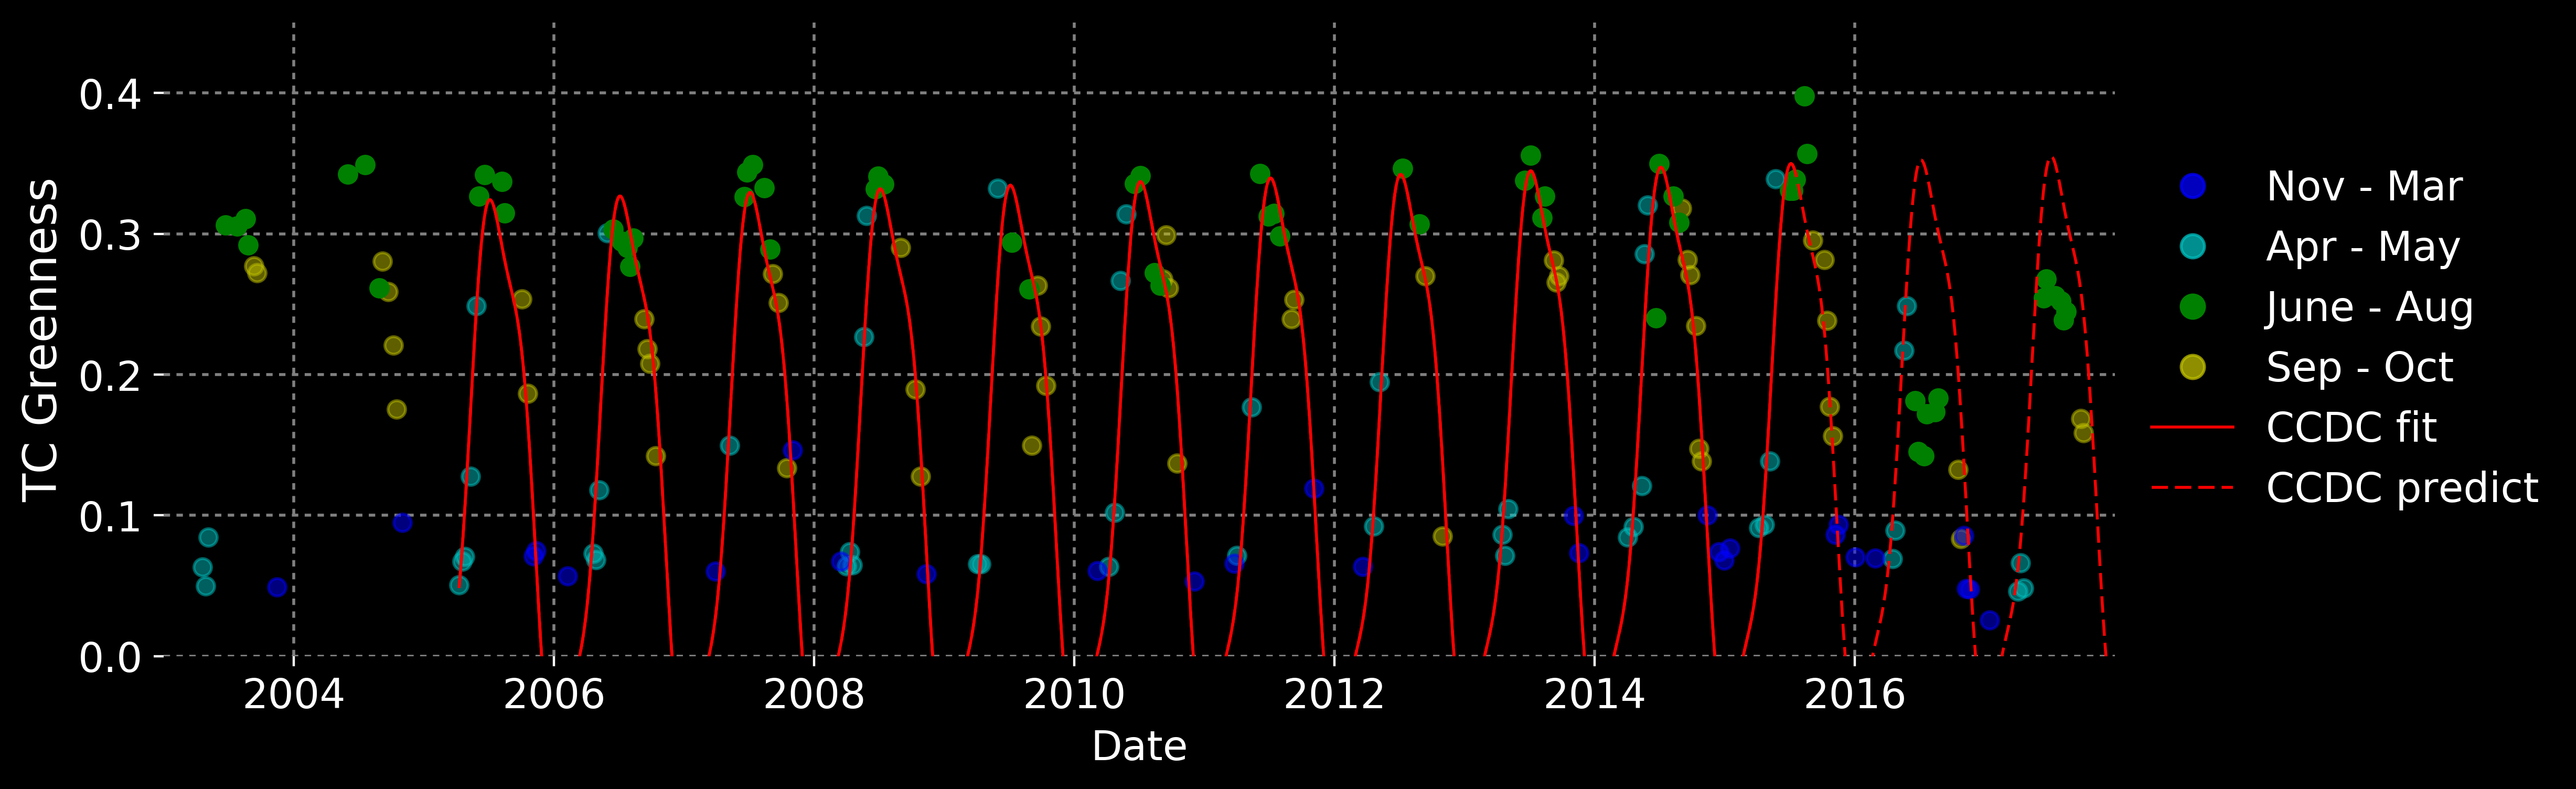

In [11]:
#def pixel(ctx, config, px, py, band, plot, ylim, style, cmap,
#          embed, seed, algo_kw, result_prefix, seasons):
    # Set seed
config_fit = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_moths_paper.yaml'
config_predict = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

start = dt.datetime.strptime('2005 01', '%Y %j')
end = dt.datetime.strptime('2016 365', '%Y %j')
    
np.random.seed(seed)

# Format result prefix
print(result_prefix)
#if result_prefix:
#    result_prefix = set((_pref if _pref[-1] == '_' else _pref + '_')
#                     for _pref in result_prefix)
#    result_prefix.add('')  # add in no prefix to show original fit
#else:
#    result_prefix = ('', )
#print(result_prefix)

# Get colormap
if cmap not in mpl.cm.cmap_d:
    raise click.ClickException('Cannot find specified colormap ({}) in '
                               'matplotlib'.format(cmap))

######################################    
# Parse config for fitting
cfg = parse_config_file(config_fit)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df = csvfile_to_dataframe(cfg['dataset']['input_file'],
                          date_format=cfg['dataset']['date_format'])
df['image_ID'] = get_image_IDs(df['filename'])
df['x'] = df['date']
dates = df['date'].values

# Initialize timeseries model
model = cfg['YATSM']['algorithm_object']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'],
              **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X = yatsm.setup(df, **cfg)
design_info = getattr(X, 'design_info', None)

# Read pixel data
Y = read_pixel_timeseries(df['filename'], px, py)
if Y.shape[0] != cfg['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df['filename'][0],
            nf=Y.shape[0],
            nc=cfg['dataset']['n_bands']))

# Preprocess pixel data
X, Y, dates = yatsm.preprocess(X, Y, dates, **cfg['dataset'])
#Y = Y.astype(float)/10000

# Convert ordinal to datetime
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

######################################    
# Parse config for predicting
cfg_pred = parse_config_file(config_predict)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df_pred = csvfile_to_dataframe(cfg_pred['dataset']['input_file'],
                          date_format=cfg_pred['dataset']['date_format'])
df_pred['image_ID'] = get_image_IDs(df_pred['filename'])
df_pred['x'] = df_pred['date']
dates_pred = df_pred['date'].values

# Initialize timeseries model
#model = ['YATSM']['algorithm_object']
algo_cfg_pred = cfg_pred[cfg_pred['YATSM']['algorithm']]
yatsm_pred = model(estimator=cfg_pred['YATSM']['estimator'],
              **algo_cfg_pred.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X_pred= yatsm.setup(df_pred, **cfg_pred)
design_info = getattr(X_pred, 'design_info', None)

# Read pixel data
Y_pred = read_pixel_timeseries(df_pred['filename'], px, py)
if Y_pred.shape[0] != cfg_pred['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df_pred['filename'][0],
            nf=Y_pred.shape[0],
            nc=cfg_pred['dataset']['n_bands']))

# Preprocess pixel data
X_pred, Y_pred, dates_pred = yatsm.preprocess(X_pred, Y_pred, dates_pred, **cfg_pred['dataset'])
Y_pred = Y_pred.astype(float)/10000

# Convert ordinal to datetime
dt_dates_pred = np.array([dt.datetime.fromordinal(d) for d in dates_pred])

# Fit model
yatsm.fit(X, Y, dates, **algo_cfg.get('fit', {}))
for prefix, estimator, stay_reg, fitopt in zip(
        cfg['YATSM']['refit']['prefix'],
        cfg['YATSM']['refit']['prediction_object'],
        cfg['YATSM']['refit']['stay_regularized'],
        cfg['YATSM']['refit']['fit']):
    yatsm.record = postprocess.refit_record(
        yatsm, prefix, estimator,
        fitopt=fitopt, keep_regularized=stay_reg)

# Plot after predictions
#plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(12,4), dpi=400)
ax1 = plt.axes(frameon=False)

#ax.plot(range(20))
#ax.axvspan(start, end, alpha=0.1, color='w')
                
with plt.xkcd() if style == 'xkcd' else mpl.style.context(style):
        #for _plot in plot:
        _plot = 'TS'   
        if _plot == 'TS':
            plot_TS(dt_dates_pred, Y_pred[band, :], seasons)
        elif _plot == 'DOY':
            plot_DOY(dt_dates, Y[band, :], cmap)
        elif _plot == 'VAL':
            plot_VAL(dt_dates, Y[band, :], cmap)

        if ylim:
            plt.ylim(ylim)
        #plt.title('Timeseries: px={px} py={py}'.format(px=px, py=py), loc='left')
        #plt.title('Example: Stable Pine Plantation')
        #plt.ylabel('Band {b}'.format(b=band + 1))

        if band == 6:
            plt.ylabel('Brightness Temp (K)', fontsize=16)
        elif band == 7:
            plt.ylabel('TC Brightness', fontsize=16)
        elif band == 8:
            plt.ylabel('TC Greenness', fontsize=16, color='w')
        elif band == 9:
            plt.ylabel('TC Wetness', fontsize=16)
        else: 
            plt.ylabel('Band {b}'.format(b=band + 1))

        #for _prefix in set(result_prefix):
        #_prefix='ols_'; # visualize only final ols results
        plot_results_fit(band, cfg, yatsm, design_info,
                        result_prefix=result_prefix,
                        plot_type=_plot)
        plot_results_predict(band, cfg_pred, yatsm, design_info,
                result_prefix=result_prefix,
                plot_type=_plot)
plt.yticks(fontsize=14, color='w')
plt.xticks(fontsize=14, rotation=0, color='w')
#plt.xlabel('Date', fontsize=0, color='w')

#plt.axvline(dt.datetime.strptime('2013 1', '%Y %j'), lw=1, color='w', ls='--')
#plt.axvline(dt.datetime.strptime('2016 350', '%Y %j'), lw=1, color='w', ls='--')

winter_mk = mlines.Line2D([], [], color='b', marker='o',
                          markersize=8, label='Nov - Mar', alpha=0.75, lw=0)
summer_mk = mlines.Line2D([], [], color='g', marker='o',
                          markersize=8, label='June - Aug', alpha=1, lw=0)
spring_mk = mlines.Line2D([], [], color='c', marker='o',
                          markersize=8, label='Apr - May', alpha=0.75, lw=0)
fall_mk = mlines.Line2D([], [], color='y', marker='o',
                          markersize=8, label='Sep - Oct', alpha=0.75, lw=0)
fit_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC fit', lw=1)
predict_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC predict', lw=1, ls='--')
leg = plt.legend(handles=[winter_mk, spring_mk, summer_mk, fall_mk, fit_mk, predict_mk],
           numpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, fancybox=True)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0)

plt.grid(True)

#plt.tight_layout()
plt.show()
#ax.set_rasterized(True)
fig.savefig('{WRS}_{px}-{py}_2005-2015_TCG.png'.format(WRS=WRS, px=px, py=py), 
            bbox_extra_artists=(leg,), bbox_inches='tight', dpi=400)


In [ ]:
#def pixel(ctx, config, px, py, band, plot, ylim, style, cmap,
#          embed, seed, algo_kw, result_prefix, seasons):
    # Set seed
config_fit = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_moths_paper.yaml'
config_predict = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

start1 = dt.datetime.strptime('2016 150', '%Y %j')
end1 = dt.datetime.strptime('2016 250', '%Y %j')

start2 = dt.datetime.strptime('2017 150', '%Y %j')
end2 = dt.datetime.strptime('2017 250', '%Y %j')

xmin = dt.datetime.strptime('2013 1', '%Y %j')
xmax = dt.datetime.strptime('2017 365', '%Y %j')
    
np.random.seed(seed)

# Format result prefix
print(result_prefix)
#if result_prefix:
#    result_prefix = set((_pref if _pref[-1] == '_' else _pref + '_')
#                     for _pref in result_prefix)
#    result_prefix.add('')  # add in no prefix to show original fit
#else:
#    result_prefix = ('', )
#print(result_prefix)

# Get colormap
if cmap not in mpl.cm.cmap_d:
    raise click.ClickException('Cannot find specified colormap ({}) in '
                               'matplotlib'.format(cmap))

######################################    
# Parse config for fitting
cfg = parse_config_file(config_fit)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df = csvfile_to_dataframe(cfg['dataset']['input_file'],
                          date_format=cfg['dataset']['date_format'])
df['image_ID'] = get_image_IDs(df['filename'])
df['x'] = df['date']
dates = df['date'].values

# Initialize timeseries model
model = cfg['YATSM']['algorithm_object']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'],
              **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X = yatsm.setup(df, **cfg)
design_info = getattr(X, 'design_info', None)

# Read pixel data
Y = read_pixel_timeseries(df['filename'], px, py)
if Y.shape[0] != cfg['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df['filename'][0],
            nf=Y.shape[0],
            nc=cfg['dataset']['n_bands']))

# Preprocess pixel data
X, Y, dates = yatsm.preprocess(X, Y, dates, **cfg['dataset'])
#Y = Y.astype(float)/10000

# Convert ordinal to datetime
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

######################################    
# Parse config for predicting
cfg_pred = parse_config_file(config_predict)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df_pred = csvfile_to_dataframe(cfg_pred['dataset']['input_file'],
                          date_format=cfg_pred['dataset']['date_format'])
df_pred['image_ID'] = get_image_IDs(df_pred['filename'])
df_pred['x'] = df_pred['date']
dates_pred = df_pred['date'].values

# Initialize timeseries model
#model = ['YATSM']['algorithm_object']
algo_cfg_pred = cfg_pred[cfg_pred['YATSM']['algorithm']]
yatsm_pred = model(estimator=cfg_pred['YATSM']['estimator'],
              **algo_cfg_pred.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X_pred= yatsm.setup(df_pred, **cfg_pred)
design_info = getattr(X_pred, 'design_info', None)

# Read pixel data
Y_pred = read_pixel_timeseries(df_pred['filename'], px, py)
if Y_pred.shape[0] != cfg_pred['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df_pred['filename'][0],
            nf=Y_pred.shape[0],
            nc=cfg_pred['dataset']['n_bands']))

# Preprocess pixel data
X_pred, Y_pred, dates_pred = yatsm.preprocess(X_pred, Y_pred, dates_pred, **cfg_pred['dataset'])
Y_pred = Y_pred.astype(float)/10000

# Convert ordinal to datetime
dt_dates_pred = np.array([dt.datetime.fromordinal(d) for d in dates_pred])

# Fit model
yatsm.fit(X, Y, dates, **algo_cfg.get('fit', {}))
for prefix, estimator, stay_reg, fitopt in zip(
        cfg['YATSM']['refit']['prefix'],
        cfg['YATSM']['refit']['prediction_object'],
        cfg['YATSM']['refit']['stay_regularized'],
        cfg['YATSM']['refit']['fit']):
    yatsm.record = postprocess.refit_record(
        yatsm, prefix, estimator,
        fitopt=fitopt, keep_regularized=stay_reg)

# Plot after predictions
#plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(12,4), dpi=400)
ax1 = plt.axes(frameon=False)

#ax.plot(range(20))
ax.axvspan(start1, end1, alpha=0.1, color='w')
ax.axvspan(start2, end2, alpha=0.1, color='w')

#plt.hold(True)
with plt.xkcd() if style == 'xkcd' else mpl.style.context(style):
        #for _plot in plot:
        _plot = 'TS'   
        if _plot == 'TS':
            plot_TS(dt_dates_pred, Y_pred[band, :], seasons)
        elif _plot == 'DOY':
            plot_DOY(dt_dates, Y[band, :], cmap)
        elif _plot == 'VAL':
            plot_VAL(dt_dates, Y[band, :], cmap)

        if ylim:
            plt.ylim(ylim)
        #plt.title('Timeseries: px={px} py={py}'.format(px=px, py=py), loc='left')
        #plt.title('Example: Stable Pine Plantation')
        #plt.ylabel('Band {b}'.format(b=band + 1))

        if band == 6:
            plt.ylabel('Brightness Temp (K)', fontsize=16)
        elif band == 7:
            plt.ylabel('TC Brightness', fontsize=16)
        elif band == 8:
            plt.ylabel('TC Greenness', fontsize=16, color='w')
        elif band == 9:
            plt.ylabel('TC Wetness', fontsize=16)
        else: 
            plt.ylabel('Band {b}'.format(b=band + 1))

        #for _prefix in set(result_prefix):
        #_prefix='ols_'; # visualize only final ols results        
        plot_results_predict(band, cfg_pred, yatsm, design_info,
                result_prefix=result_prefix,
                plot_type=_plot)
        
        plot_results_fit(band, cfg, yatsm, design_info,
                        result_prefix=result_prefix,
                        plot_type=_plot)

        
plt.xlim((xmin, xmax))
plt.yticks(fontsize=14, color='w')
plt.xticks(fontsize=14, rotation=0, color='w')  
plt.xlabel('Date', fontsize=12, color='w')

winter_mk = mlines.Line2D([], [], color='b', marker='o',
                          markersize=6, label='Nov - Mar', alpha=0.75, lw=0)
summer_mk = mlines.Line2D([], [], color='g', marker='o',
                          markersize=6, label='June - Aug', alpha=1, lw=0)
spring_mk = mlines.Line2D([], [], color='c', marker='o',
                          markersize=6, label='Apr - May', alpha=0.75, lw=0)
fall_mk = mlines.Line2D([], [], color='y', marker='o',
                          markersize=6, label='Sep - Oct', alpha=0.75, lw=0)
fit_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='model fit', lw=1)
predict_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='model predict', lw=1, ls='--')
leg = plt.legend(handles=[winter_mk, spring_mk, summer_mk, fall_mk, fit_mk, predict_mk],
           numpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, fancybox=True)
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0)

plt.grid(True)
#plt.tight_layout()
#ax.set_rasterized(True)
fig.savefig('{WRS}_{px}-{py}_2005-2015_TCG_end.png'.format(WRS=WRS, px=px, py=py), 
            bbox_extra_artists=(leg,), bbox_inches='tight', dpi=400)
plt.show()

In [ ]:
#def pixel(ctx, config, px, py, band, plot, ylim, style, cmap,
#          embed, seed, algo_kw, result_prefix, seasons):
    # Set seed
config_fit = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_moths_paper.yaml'
config_predict = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config_pixel.yaml'

start = dt.datetime.strptime('2005 01', '%Y %j')
end = dt.datetime.strptime('2015 365', '%Y %j')

xmin = dt.datetime.strptime('2013 1', '%Y %j')
xmax = dt.datetime.strptime('2017 365', '%Y %j')
    
np.random.seed(seed)

# Format result prefix
print(result_prefix)
#if result_prefix:
#    result_prefix = set((_pref if _pref[-1] == '_' else _pref + '_')
#                     for _pref in result_prefix)
#    result_prefix.add('')  # add in no prefix to show original fit
#else:
#    result_prefix = ('', )
#print(result_prefix)

# Get colormap
if cmap not in mpl.cm.cmap_d:
    raise click.ClickException('Cannot find specified colormap ({}) in '
                               'matplotlib'.format(cmap))

######################################    
# Parse config for fitting
cfg = parse_config_file(config_fit)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df = csvfile_to_dataframe(cfg['dataset']['input_file'],
                          date_format=cfg['dataset']['date_format'])
df['image_ID'] = get_image_IDs(df['filename'])
df['x'] = df['date']
dates = df['date'].values

# Initialize timeseries model
model = cfg['YATSM']['algorithm_object']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'],
              **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X = yatsm.setup(df, **cfg)
design_info = getattr(X, 'design_info', None)

# Read pixel data
Y = read_pixel_timeseries(df['filename'], px, py)
if Y.shape[0] != cfg['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df['filename'][0],
            nf=Y.shape[0],
            nc=cfg['dataset']['n_bands']))

# Preprocess pixel data
X, Y, dates = yatsm.preprocess(X, Y, dates, **cfg['dataset'])
#Y = Y.astype(float)/10000

# Convert ordinal to datetime
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

######################################    
# Parse config for predicting
cfg_pred = parse_config_file(config_predict)

# Apply algorithm overrides
for kw in algo_kw:
    value = yaml.load(algo_kw[kw])
    cfg = trawl_replace_keys(cfg, kw, value)
if algo_kw:  # revalidate configuration
    cfg = convert_config(cfg)

# Dataset information
df_pred = csvfile_to_dataframe(cfg_pred['dataset']['input_file'],
                          date_format=cfg_pred['dataset']['date_format'])
df_pred['image_ID'] = get_image_IDs(df_pred['filename'])
df_pred['x'] = df_pred['date']
dates_pred = df_pred['date'].values

# Initialize timeseries model
#model = ['YATSM']['algorithm_object']
algo_cfg_pred = cfg_pred[cfg_pred['YATSM']['algorithm']]
yatsm_pred = model(estimator=cfg_pred['YATSM']['estimator'],
              **algo_cfg_pred.get('init', {}))
yatsm.px = px
yatsm.py = py

# Setup algorithm and create design matrix (if needed)
X_pred= yatsm.setup(df_pred, **cfg_pred)
design_info = getattr(X_pred, 'design_info', None)

# Read pixel data
Y_pred = read_pixel_timeseries(df_pred['filename'], px, py)
if Y_pred.shape[0] != cfg_pred['dataset']['n_bands']:
    raise click.ClickException(
        'Number of bands in image {f} ({nf}) do not match number in '
        'configuration file ({nc})'.format(
            f=df_pred['filename'][0],
            nf=Y_pred.shape[0],
            nc=cfg_pred['dataset']['n_bands']))

# Preprocess pixel data
X_pred, Y_pred, dates_pred = yatsm.preprocess(X_pred, Y_pred, dates_pred, **cfg_pred['dataset'])
Y_pred = Y_pred.astype(float)/10000

# Convert ordinal to datetime
dt_dates_pred = np.array([dt.datetime.fromordinal(d) for d in dates_pred])

# Fit model
yatsm.fit(X, Y, dates, **algo_cfg.get('fit', {}))
for prefix, estimator, stay_reg, fitopt in zip(
        cfg['YATSM']['refit']['prefix'],
        cfg['YATSM']['refit']['prediction_object'],
        cfg['YATSM']['refit']['stay_regularized'],
        cfg['YATSM']['refit']['fit']):
    yatsm.record = postprocess.refit_record(
        yatsm, prefix, estimator,
        fitopt=fitopt, keep_regularized=stay_reg)

# Plot after predictions
#plt.figure(figsize=(14,4))
fig, ax = plt.subplots(figsize=(12,4), dpi=400)
ax1 = plt.axes(frameon=False)

#ax.plot(range(20))
ax.axvspan(start, end, alpha=0.1, color='w')
                
#plt.hold(True)
with plt.xkcd() if style == 'xkcd' else mpl.style.context(style):
        #for _plot in plot:
        _plot = 'TS'   
        if _plot == 'TS':
            plot_TS(dt_dates_pred, Y_pred[band, :], seasons)
        elif _plot == 'DOY':
            plot_DOY(dt_dates, Y[band, :], cmap)
        elif _plot == 'VAL':
            plot_VAL(dt_dates, Y[band, :], cmap)

        if ylim:
            plt.ylim(ylim)
        #plt.title('Timeseries: px={px} py={py}'.format(px=px, py=py), loc='left')
        #plt.title('Example: Stable Pine Plantation')
        #plt.ylabel('Band {b}'.format(b=band + 1))

        if band == 6:
            plt.ylabel('Brightness Temp (K)', fontsize=16)
        elif band == 7:
            plt.ylabel('TC Brightness', fontsize=16)
        elif band == 8:
            plt.ylabel('TC Greenness', fontsize=16, color='w')
        elif band == 9:
            plt.ylabel('TC Wetness', fontsize=16)
        else: 
            plt.ylabel('Band {b}'.format(b=band + 1))

        #for _prefix in set(result_prefix):
        #_prefix='ols_'; # visualize only final ols results
        plot_results_fit(band, cfg, yatsm, design_info,
                        result_prefix=result_prefix,
                        plot_type=_plot)
        plot_results_predict(band, cfg_pred, yatsm, design_info,
                result_prefix=result_prefix,
                plot_type=_plot)
        
plt.xlim((xmin, xmax))
plt.yticks(fontsize=14, color='w')
plt.xticks(fontsize=14, rotation=0, color='w')  
plt.xlabel('Date', fontsize=12, color='w')

winter_mk = mlines.Line2D([], [], color='b', marker='o',
                          markersize=6, label='Nov - Mar', alpha=0.75, lw=0)
summer_mk = mlines.Line2D([], [], color='g', marker='o',
                          markersize=6, label='June - Aug', alpha=1, lw=0)
spring_mk = mlines.Line2D([], [], color='c', marker='o',
                          markersize=6, label='Apr - May', alpha=0.75, lw=0)
fall_mk = mlines.Line2D([], [], color='y', marker='o',
                          markersize=6, label='Sep - Oct', alpha=0.75, lw=0)
fit_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC fit', lw=1)
predict_mk = mlines.Line2D([], [], color='r', marker='o',
                          markersize=0, label='CCDC predict', lw=1, ls='--')
#leg = plt.legend(handles=[winter_mk, spring_mk, summer_mk, fall_mk, fit_mk, predict_mk],
#           numpoints=1, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14, fancybox=True)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0)

plt.grid(True)
#plt.tight_layout()
#ax.set_rasterized(True)

fig.savefig('{WRS}_{px}-{py}_2005-2015_TCG_end.png'.format(WRS=WRS, px=px, py=py), 
            bbox_extra_artists=(leg,), bbox_inches='tight', dpi=400)
plt.show()